In [142]:
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipkinc, ellipeinc, ellipk
import cmath

In [143]:
def calcQ(P: float,bh_mass: float, tol=1e-3) ->float:
    Q=np.sqrt((P - 2.*bh_mass)*(P + 6.*bh_mass))
    return Q

def bfromP(P: float,bh_mass: float, tol: float=1e-5) ->float:
    b = np.sqrt(P**3/(P - 2.*bh_mass))
    return b

def zetainf(P: float,bh_mass: float, tol=1e-6) ->float:
    Q = calcQ(P,bh_mass)
    arg =(Q-P+2.*bh_mass)/(Q-P + 6.*bh_mass)
    z_inf = np.arcsin(np.sqrt(arg))
    return z_inf

def k(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k = np.sqrt((Q-P+6*bh_mass)/(2*Q))
    return k

def k2(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k2 = (Q-P+6*bh_mass)/(2*Q)
    return k2

def cosgamma(_a: float, incl: float, tol=1e-5) -> float:
    if abs(incl) <tol:
        return 0
    return np.cos(_a)/np.sqrt(np.cos(_a)**2+1/(np.tan(incl)**2))

def eq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=g/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)

def midpoint_method(func,args:Dict, __x,__y,__ind):
    new_x = __x
    new_y = __y
    x_ = [new_x[__ind],new_x[__ind+1]]
    inbetween_x = np.mean(x_)
    new_x.insert(__ind+1,inbetween_x)
    
    y_ = [new_y[__ind],new_y[__ind+1]]
    inbetween_solution = func(P=inbetween_x, **args)
    new_y.insert(__ind+1,inbetween_solution)
    y_.insert(1, inbetween_solution)
    ind_of_sign_change_ =np.where(np.diff(np.sign(y_)))[0]
    new_ind=__ind + ind_of_sign_change_[0]
    return new_x, new_y, new_ind

def improve_solutions_midpoint(func, args, x, y, index_of_sign_change, iterations) -> float:
    index_of_sign_change_ = index_of_sign_change
    new_x =x
    new_y =y
    new_ind = index_of_sign_change_
    for iteration in range(iterations):
        new_x, new_y, new_ind = midpoint_method(func=func, args=args, __x=new_x, __y=new_y, __ind = new_ind)
    updated_P = new_x[new_ind]
    return updated_P

def calcP(_r, incl, _alpha, bh_mass, midpoint_iterations =100, plot_inbetween=False, n=0, min_P=1., initial_guesses=20) -> float:
    def get_plot(X,Y,solution, radius=_r):
        fig=plt.figure()
        plt.title("eq13(P)\nr={}, a={}".format(radius, round(_alpha,5)))
        plt.xlabel('P')
        plt.ylabel('Eq13(P)')
        plt.axhline(0,color='black')
        plt.plot(X,Y)
        plt.scatter(solution, 0, color='red')
        return plt
    periastron_range =list(np.linspace(min_P, 2.*_r, initial_guesses))
    y_ = [eq13(P_value, _r,_alpha, bh_mass, incl, n) for P_value in periastron_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    periastron_solution = periastron_range[ind[0]] if len(ind) else None
    if(periastron_solution is not None) and (not np.isnan(periastron_solution)):
        args_eq13 ={"ir_radius":_r, "ir_angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n}
        periastron_solution = \
        improve_solutions_midpoint(func=eq13, args=args_eq13, x=periastron_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    if plot_inbetween:
        get_plot(periastron_range, y_, periastron_solution).show
    return periastron_solution

def ellipse(r,a,incl):
    g=np.arccos(cosgamma(a,incl))
    b_=r*np.sin(g)
    return b_

def calcb(_r, incl, _alpha, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses) -> float:
    periastron_solution = calcP(_r,incl,_alpha,bh_mass, midpoint_iterations, plot_inbetween,n,min_P,initial_guesses)
    if periastron_solution is None or periastron_solution <=2.*bh_mass:
        return ellipse(_r, _alpha,incl)
    elif periastron_solution >2.*bh_mass:
        b=bfromP(periastron_solution, bh_mass)
        return b
    else:
        raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")

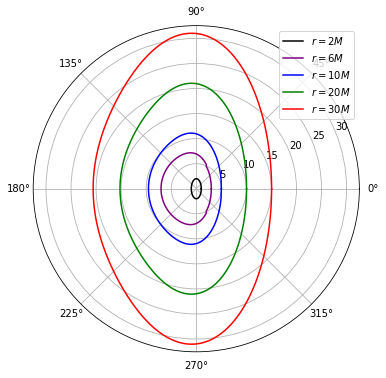

In [11]:
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_30 = np.empty(1000)
isoradials_6_30 = np.empty(1000)
isoradials_10_30 = np.empty(1000)
isoradials_20_30 = np.empty(1000)
isoradials_30_30 = np.empty(1000)

for i in range(0,1000):
    isoradials_2_30[i]= calcb(2, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_6_30[i]= calcb(6, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_10_30[i]= calcb(10, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_20_30[i]= calcb(20, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_30_30[i]= calcb(30, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_30, color= 'black', label="$r=2M$")
ax.plot(alphas, isoradials_6_30, color= 'purple', label="$r=6M$")
ax.plot(alphas, isoradials_10_30, color= 'blue', label="$r=10M$")
ax.plot(alphas, isoradials_20_30, color= 'green', label="$r=20M$")
ax.plot(alphas, isoradials_30_30, color= 'red', label="$r=30M$")
plt.legend()
plt.show()

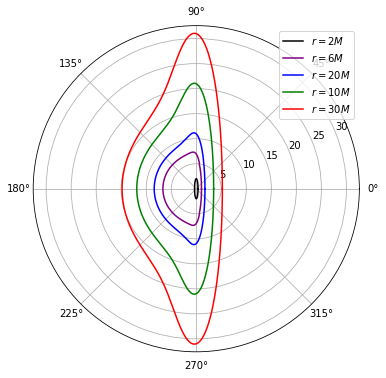

In [66]:
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_10 = np.empty(1000)
isoradials_6_10 = np.empty(1000)
isoradials_10_10 = np.empty(1000)
isoradials_20_10 = np.empty(1000)
isoradials_30_10 = np.empty(1000)

for i in range(0,1000):
    isoradials_2_10[i]= calcb(2, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_6_10[i]= calcb(6, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_10_10[i]= calcb(10, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_20_10[i]= calcb(20, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_30_10[i]= calcb(30, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'black', label="$r=2M$")
ax.plot(alphas, isoradials_6_10, color= 'purple', label="$r=6M$")
ax.plot(alphas, isoradials_10_10, color= 'blue', label="$r=20M$")
ax.plot(alphas, isoradials_20_10, color= 'green', label="$r=10M$")
ax.plot(alphas, isoradials_30_10, color= 'red', label="$r=30M$")
plt.legend()
plt.show()

In [140]:
#and now for the corrections. why do I do this to myself
def correction(P: float, bh_mass: float, ir_radius: float) -> float:
    b = bfromP(P, bh_mass)
    h = (((b**2+6*cmath.sqrt(81-3*b**2)-54)*b)**(1/3))/b
    a1 = (((b**2+6*cmath.sqrt(81-3*b**2)-54)*b)**(1/3))/b
    a2 = 1/3*(cmath.sqrt(complex(0,-3/(h-1/h)*(complex(1/ir_radius+h/2+1/(2*h)-1,np.sqrt(3)/2*(h-1/h))))))
    a3 = cmath.sqrt(complex(0,2*np.sqrt(3)/complex(3*h+3/h,np.sqrt(3)*(h-1/h))))
    a4 = 1/cmath.sqrt(2/(ir_radius**3) -1/(ir_radius**2)+1/(b**2))
    a5 = (h/6 +1/(6*h)+1/6)
    a6 = cmath.sqrt(-((1/ir_radius+h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*(1/ir_radius-a5)/complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a7 = cmath.sqrt(-((1/ir_radius+h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*(1/ir_radius-a5)*complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a8 = a4*ellipkinc(a2.real,a3.real)*(a6*(complex(0,4*np.sqrt(3)*((b**2+60)/(b**-27))/(3*b**2))+complex(0,32*np.sqrt(3)/(5*b**2)))+a5*(1/45-2/(3*b**2)+a5/(15*b**4)))
    a9 = a4*ellipeinc(a2.real,a3.real)*(a6*(112*np.sqrt(3)/45)+a7*complex(0,(4*np.sqrt(3)*(b**2+4)/(15*b**4))-4*np.sqrt(3)*(11*b**2-36)/(3*b**2*(b**2-27))))
    a10 = 2*(2*a4*(11*b**2-36)/ir_radius**2-(b**2+60)/ir_radius-b**2+2)/(b**2*(b**2-27))
    a11= 56/(15*a4)
    a12 = 8/(5*ir_radius*a4)
    a02 = 1/3*(cmath.sqrt(complex(0,-3/(h-1/h)*(complex(h/2+1/(2*h)-1,np.sqrt(3)/2*(h-1/h))))))
    a06 = cmath.sqrt(((h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*a5/complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a07 = cmath.sqrt(((h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*a5*complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a08 = a4*ellipkinc(a02.real,a3.real)*(a06*complex(0,(4*np.sqrt(3)*((b**2+60)/(b**-27))/(3*b**2))+32*np.sqrt(3)/(5*b**2))+a5*(1/45-2/(3*b**2)+a5/(15*b**4)))
    a09 = a4*ellipeinc(a02.real,a3.real)*(a06*(112*np.sqrt(3)/45)+a07*complex(0,(4*np.sqrt(3)*(b**2+4)/(15*b**4))-4*np.sqrt(3)*(11*b**2-36)/(3*b**2*(b**2-27))))
    a010 = 2*(b**2-2)/(b*(b**2-27))
    a011 = 56/(15*b)
    I = a8+a9+a10+a11+a12-b*a08-b*a09-a010-a011
    if np.isnan(I.real):
        return 1
    else:
        return I.real

def correctedeq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, midpoint_iterations =100, plot_inbetween = False, min_P=3.001, initial_guesses=20, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    I = correction(P, bh_mass, ir_radius)
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-0.01*I-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=(g+0.01*I)/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)
                                                                                                                      
def calccorrectedP(_r, incl, _alpha, bh_mass, midpoint_iterations =100, plot_inbetween=False, n=0, min_P=1., initial_guesses=20) -> float:
    def get_plot(X,Y,solution, radius=_r):
        fig=plt.figure()
        plt.title("correctedeq13(P)\nr={}, a={}".format(radius, round(_alpha,5)))
        plt.xlabel('P')
        plt.ylabel('CorrectedEq13(P)')
        plt.axhline(0,color='black')
        plt.plot(X,Y)
        plt.scatter(solution, 0, color='red')
        return plt
    periastron_range =list(np.linspace(min_P, 2.*_r, initial_guesses))
    y_ = [correctedeq13(P_value, _r,_alpha, bh_mass, incl, n) for P_value in periastron_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    periastron_solution = periastron_range[ind[0]] if len(ind) else None
    if(periastron_solution is not None) and (not np.isnan(periastron_solution)):
        args_eq13 ={"ir_radius":_r, "ir_angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n}
        periastron_solution = \
        improve_solutions_midpoint(func=correctedeq13, args=args_eq13, x=periastron_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    if plot_inbetween:
        get_plot(periastron_range, y_, periastron_solution).show
    return periastron_solution
                                                                                                                    
def calccorrectedb(_r, incl, _alpha, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses) -> float:
    periastron_solution = calccorrectedP(_r,incl,_alpha,bh_mass, midpoint_iterations, plot_inbetween,n,min_P,initial_guesses)
    if periastron_solution is None or periastron_solution <=2.*bh_mass:
        return ellipse(_r, _alpha,incl)
    elif periastron_solution >2.*bh_mass:
        b=bfromP(periastron_solution, bh_mass)
        return b
    else:
        raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")

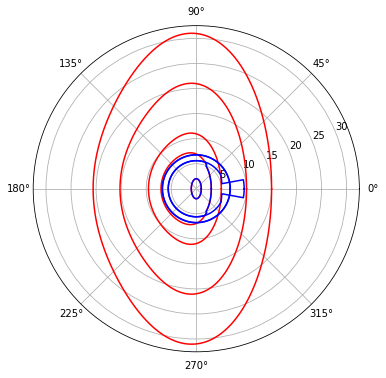

In [141]:
#t = 0.01. I am very confused as to why the graphs are behaving like this
#okay. I think it might be because the method I am using finds a solution and the approximation gives two (in MAPLE as well)

alphas = np.linspace(0, 2*np.pi, 1000)
correctedisoradials_2_30 = np.empty(1000)
correctedisoradials_6_30 = np.empty(1000)
correctedisoradials_10_30 = np.empty(1000)
correctedisoradials_20_30 = np.empty(1000)
correctedisoradials_30_30 = np.empty(1000)

for i in range(0,1000):
    correctedisoradials_2_30[i]= calccorrectedb(2, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_6_30[i]= calccorrectedb(6, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_10_30[i]= calccorrectedb(10, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_20_30[i]= calccorrectedb(20, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_30_30[i]= calccorrectedb(30, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_30, color= 'red')
ax.plot(alphas, isoradials_6_30, color= 'red')
ax.plot(alphas, isoradials_10_30, color= 'red')
ax.plot(alphas, isoradials_20_30, color= 'red')
ax.plot(alphas, isoradials_30_30, color= 'red')
ax.plot(alphas, correctedisoradials_2_30, color= 'blue')
ax.plot(alphas, correctedisoradials_6_30, color= 'blue')
ax.plot(alphas, correctedisoradials_10_30, color= 'blue')
ax.plot(alphas, correctedisoradials_20_30, color= 'blue')
ax.plot(alphas, correctedisoradials_30_30, color= 'blue')
plt.show()

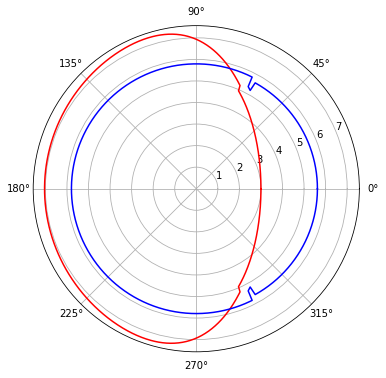

In [133]:
#t = 0.1
for i in range(0,1000):
    correctedisoradials_6_30[i]= calccorrectedb(6, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_6_30, color= 'red')
ax.plot(alphas, correctedisoradials_6_30, color= 'blue')
plt.show()

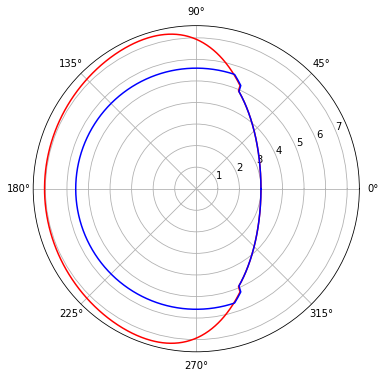

In [135]:
#t=0.01

for i in range(0,1000):
    correctedisoradials_6_30[i]= calccorrectedb(6, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_6_30, color= 'red')
ax.plot(alphas, correctedisoradials_6_30, color= 'blue')
plt.show()

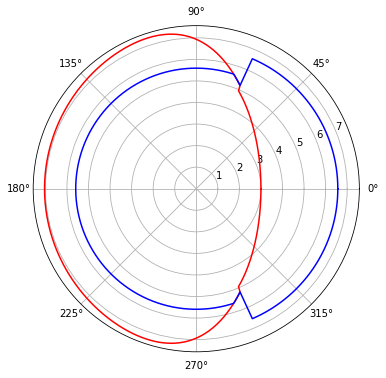

In [137]:
#t=0.001
for i in range(0,1000):
    correctedisoradials_6_30[i]= calccorrectedb(6, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_6_30, color= 'red')
ax.plot(alphas, correctedisoradials_6_30, color= 'blue')
plt.show()

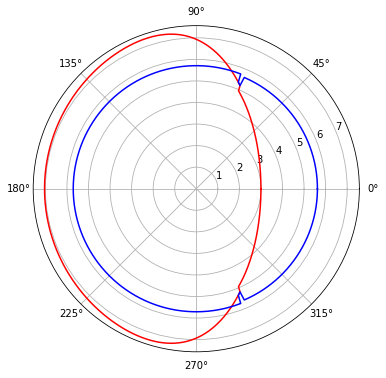

In [139]:
#t=0.0001
for i in range(0,1000):
    correctedisoradials_6_30[i]= calccorrectedb(6, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_6_30, color= 'red')
ax.plot(alphas, correctedisoradials_6_30, color= 'blue')
plt.show()

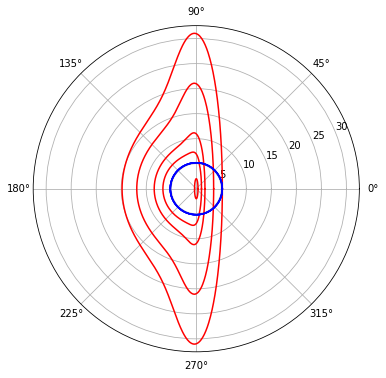

In [67]:
alphas = np.linspace(0, 2*np.pi, 1000)
correctedisoradials_2_10 = np.empty(1000)
correctedisoradials_6_10 = np.empty(1000)
correctedisoradials_10_10 = np.empty(1000)
correctedisoradials_20_10 = np.empty(1000)
correctedisoradials_30_10 = np.empty(1000)

for i in range(0,1000):
    correctedisoradials_2_10[i]= calccorrectedb(2, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_6_10[i]= calccorrectedb(6, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_10_10[i]= calccorrectedb(10, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_20_10[i]= calccorrectedb(20, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    correctedisoradials_30_10[i]= calccorrectedb(30, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'red')
ax.plot(alphas, isoradials_6_10, color= 'red')
ax.plot(alphas, isoradials_10_10, color= 'red')
ax.plot(alphas, isoradials_20_10, color= 'red')
ax.plot(alphas, isoradials_30_10, color= 'red')
ax.plot(alphas, correctedisoradials_2_10, color= 'blue')
ax.plot(alphas, correctedisoradials_6_10, color= 'blue')
ax.plot(alphas, correctedisoradials_10_10, color= 'blue')
ax.plot(alphas, correctedisoradials_20_10, color= 'blue')
ax.plot(alphas, correctedisoradials_30_10, color= 'blue')
plt.show()

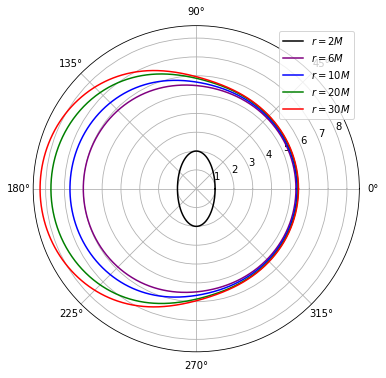

In [53]:
alphas = np.linspace(0, 2*np.pi, 1000)
secondary_isoradials_2_30 = np.empty(1000)
secondary_isoradials_6_30 = np.empty(1000)
secondary_isoradials_10_30 = np.empty(1000)
secondary_isoradials_20_30 = np.empty(1000)
secondary_isoradials_30_30 = np.empty(1000)

for i in range(0,1000):
    secondary_isoradials_2_30[i]= calcb(2, np.pi/3, alphas[i], 1, 100, False, 1, 3.001, 20)
    secondary_isoradials_6_30[i]= calcb(6, np.pi/3, alphas[i], 1, 100, False, 1, 3.001, 20)
    secondary_isoradials_10_30[i]= calcb(10, np.pi/3, alphas[i], 1, 100, False, 1, 3.001, 20)
    secondary_isoradials_20_30[i]= calcb(20, np.pi/3, alphas[i], 1, 100, False, 1, 3.001, 20)
    secondary_isoradials_30_30[i]= calcb(30, np.pi/3, alphas[i], 1, 100, False, 1, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, secondary_isoradials_2_30, color= 'black', label="$r=2M$")
ax.plot(alphas, secondary_isoradials_6_30, color= 'purple', label="$r=6M$")
ax.plot(alphas, secondary_isoradials_10_30, color= 'blue', label="$r=10M$")
ax.plot(alphas, secondary_isoradials_20_30, color= 'green', label="$r=20M$")
ax.plot(alphas, secondary_isoradials_30_30, color= 'red', label="$r=30M$")
plt.legend()
plt.show()

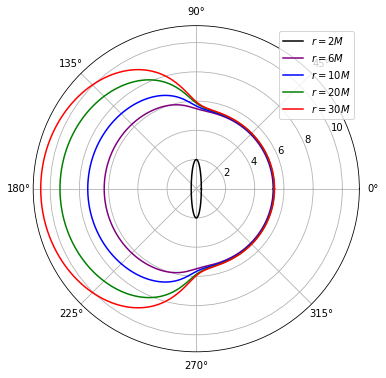

In [54]:
alphas = np.linspace(0, 2*np.pi, 1000)
secondary_isoradials_2_10 = np.empty(1000)
secondary_isoradials_6_10 = np.empty(1000)
secondary_isoradials_10_10 = np.empty(1000)
secondary_isoradials_20_10 = np.empty(1000)
secondary_isoradials_30_10 = np.empty(1000)

for i in range(0,1000):
    secondary_isoradials_2_10[i]= calcb(2, 4*np.pi/9, alphas[i], 1, 100, False, 1, 3.001, 2)
    secondary_isoradials_6_10[i]= calcb(6, 4*np.pi/9, alphas[i], 1, 100, False, 1, 3.001, 2)
    secondary_isoradials_10_10[i]= calcb(10, 4*np.pi/9, alphas[i], 1, 100, False, 1, 3.001, 2)
    secondary_isoradials_20_10[i]= calcb(20, 4*np.pi/9, alphas[i], 1, 100, False, 1, 3.001, 2)
    secondary_isoradials_30_10[i]= calcb(30, 4*np.pi/9, alphas[i], 1, 100, False, 1, 3.001, 2)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, secondary_isoradials_2_10, color= 'black', label="$r=2M$")
ax.plot(alphas, secondary_isoradials_6_10, color= 'purple', label="$r=6M$")
ax.plot(alphas, secondary_isoradials_10_10, color= 'blue', label="$r=10M$")
ax.plot(alphas, secondary_isoradials_20_10, color= 'green', label="$r=20M$")
ax.plot(alphas, secondary_isoradials_30_10, color= 'red', label="$r=30M$")
plt.legend()
plt.show()

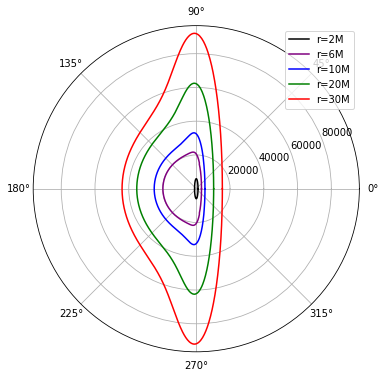

In [57]:
#until I can figure out what is going wrong with my corrections, I would like to write a code that does not set M=1
#so that I can see how the t value affects them more accurately once the correctios are working
#however, I'm not sure what the mass of the small black holes for t ~ 10^-9 is
#so until then, here's a setup code for a 1 solar mass BH
M0 = 2*6.67*10**(-11)*2*10**30/(3*10**8)**2
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_10 = np.empty(1000)
isoradials_6_10 = np.empty(1000)
isoradials_10_10 = np.empty(1000)
isoradials_20_10 = np.empty(1000)
isoradials_30_10 = np.empty(1000)

for i in range(0,1000):
    isoradials_2_10[i]= calcb(2*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_6_10[i]= calcb(6*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_10_10[i]= calcb(10*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_20_10[i]= calcb(20*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_30_10[i]= calcb(30*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'black', label="r=2M")
ax.plot(alphas, isoradials_6_10, color= 'purple', label="r=6M")
ax.plot(alphas, isoradials_10_10, color= 'blue', label="r=10M")
ax.plot(alphas, isoradials_20_10, color= 'green', label="r=20M")
ax.plot(alphas, isoradials_30_10, color= 'red', label="r=30M")
plt.legend()
plt.show()

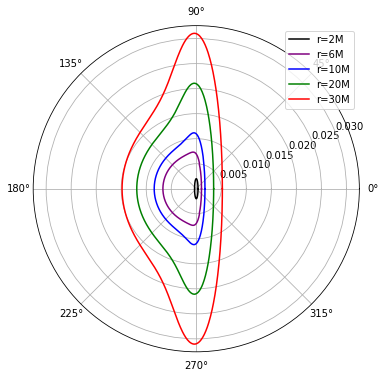

In [58]:
#and here's a code for if I'm remembering correctly and the length scale is 10^-3
M0 = 10**(-3)
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_10 = np.empty(1000)
isoradials_6_10 = np.empty(1000)
isoradials_10_10 = np.empty(1000)
isoradials_20_10 = np.empty(1000)
isoradials_30_10 = np.empty(1000)

for i in range(0,1000):
    isoradials_2_10[i]= calcb(2*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_6_10[i]= calcb(6*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_10_10[i]= calcb(10*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_20_10[i]= calcb(20*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)
    isoradials_30_10[i]= calcb(30*M0, 4*np.pi/9, alphas[i], M0, 100, False, 0, 3.001*M0, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'black', label="r=2M")
ax.plot(alphas, isoradials_6_10, color= 'purple', label="r=6M")
ax.plot(alphas, isoradials_10_10, color= 'blue', label="r=10M")
ax.plot(alphas, isoradials_20_10, color= 'green', label="r=20M")
ax.plot(alphas, isoradials_30_10, color= 'red', label="r=30M")
plt.legend()
plt.show()

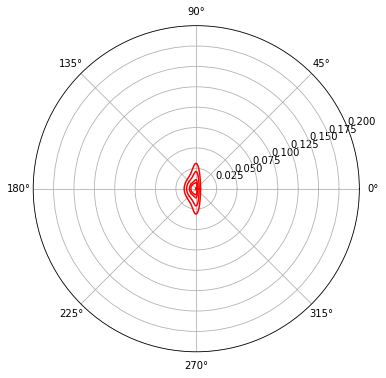

In [65]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'red')
ax.plot(alphas, isoradials_6_10, color= 'red')
ax.plot(alphas, isoradials_10_10, color= 'red')
ax.plot(alphas, isoradials_20_10, color= 'red')
ax.plot(alphas, isoradials_30_10, color= 'red')
ax.plot(alphas, correctedisoradials_2_10, color= 'blue')
ax.plot(alphas, correctedisoradials_6_10, color= 'blue')
ax.plot(alphas, correctedisoradials_10_10, color= 'blue')
ax.plot(alphas, correctedisoradials_20_10, color= 'blue')
ax.plot(alphas, correctedisoradials_30_10, color= 'blue')
ax.set_rlim(0,0.2)
plt.show()